# Implementation of Rotation-Invariant CNN Using PyTorch

This notebook focuses on the implementation of a Convolutional Neural Network (CNN) designed to be invariant to the orientation of features in the input data. The theoretical background and mathematical formulation are detailed in [this notebook](https://colab.research.google.com/drive/1FtJcQycf_XP6kAB_jJTuQAknxQiRnEj-?usp=drive_link). Here, we will develop, train, and evaluate the CNN using PyTorch.


In [1]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set up the GPU settings
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cpu device


In [2]:
# Data Loading

'''
nikolas' notebook
'''

# MNIST Dataset transformation
mnist_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to Tensor and scales pixels between 0 and 1
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizes the dataset
])

# Downloading and loading MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=mnist_transform)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def vector_aggregation(x):
    # Ensure input is in expected vector field format [batch, channels, height, width, 2]
    assert x.dim() == 6 and x.shape[-1] == 2, "Input must be 6D with last dim 2 (magnitude, phase)."

    #print("Size before aggregation:", x.shape)

    magnitude = x[..., 0]
    phase = x[..., 1]

    # Convert vector field to Cartesian coordinates
    x_cartesian = magnitude * torch.cos(phase)
    y_cartesian = magnitude * torch.sin(phase)

    # Sum Cartesian components across all channels
    summed_x = torch.sum(x_cartesian, dim=2, keepdim=False)
    summed_y = torch.sum(y_cartesian, dim=2, keepdim=False)

    # Convert back to polar coordinates
    output_magnitude = torch.sqrt(summed_x**2 + summed_y**2)
    output_phase = torch.atan2(summed_y, summed_x)

    #print("Size after aggregation:", torch.stack([output_magnitude, output_phase], dim=-1).squeeze(2).shape)

    return torch.stack([output_magnitude, output_phase], dim=-1)

class VectorConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True, aggregation="sum"):
    super(VectorConv2d, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = (kernel_size, kernel_size)
    self.stride = stride
    self.padding = padding
    self.aggregation = aggregation

    # Define the weights for the magnitudes and phases of the filters
    self.filter_x = nn.Parameter(torch.randn(out_channels, in_channels, *self.kernel_size))
    self.filter_y = nn.Parameter(torch.randn(out_channels, in_channels, *self.kernel_size))

    if bias:
      self.bias = nn.Parameter(torch.randn(out_channels))
    else:
      self.bias = None

  def forward(self, x):
    assert x.dim() == 5 and x.shape[-1] == 2, "Input to VectorConv2d should be 5D with last dim 2."

    magnitude = x[..., 0]
    phase = x[..., 1]

    # Convert from polar to cartesian
    x_cart = magnitude * torch.cos(phase)
    y_cart = magnitude * torch.sin(phase)

    # Rotate the filters
    rotated_filter_x = self.rotate_filters(self.filter_x)
    rotated_filter_y = self.rotate_filters(self.filter_y)
    bias = self.bias.repeat(4)

    # Apply convolution in cartesian coordinates
    real_conv = F.conv2d(x_cart, rotated_filter_x, bias, self.stride, self.padding) - \
                F.conv2d(y_cart, rotated_filter_y, None, self.stride, self.padding)
    imag_conv = F.conv2d(x_cart, rotated_filter_y, None, self.stride, self.padding) + \
                F.conv2d(y_cart, rotated_filter_x, None, self.stride, self.padding)

    # Reshape to isolate rotations to their own axis
    batch_size, _, height, width = real_conv.shape
    x_conv = real_conv.view(batch_size, self.out_channels, 4, height, width)
    y_conv = imag_conv.view(batch_size, self.out_channels, 4, height, width)

    if self.aggregation == "sum":
      # Add the outputs in cartesian coordinates
      output_x = torch.sum(x_conv, dim=2)
      output_y = torch.sum(y_conv, dim=2)

      # Convert the results to polar coordinates
      output_mag = torch.sqrt(output_x**2 + output_y**2)
      output_phase = torch.atan2(output_y, output_x)

      vectorized_output = torch.stack([output_mag, output_phase], dim=-1)
    else:
      # Convert the results to polar coordinates
      output_mag = torch.sqrt(x_conv**2 + y_conv**2)
      output_phase = torch.atan2(y_conv, x_conv)

      # Apply Max Pooling, drop excess rotation channels
      max_magnitude, max_indices = torch.max(output_mag, dim=2, keepdim=True)
      max_phase = torch.gather(output_phase, 2, max_indices)

      vectorized_output = torch.stack([max_magnitude.squeeze(2), max_phase.squeeze(2)], dim=-1)
    
    return vectorized_output

  def rotate_filters(self, filters):
    rotated_filters = torch.stack([
      filters,
      filters.transpose(2, 3).flip(2),
      filters.flip(2).flip(3),
      filters.transpose(2, 3).flip(3)
    ], dim=0).view(-1, *filters.shape[1:])
    return rotated_filters

class VectorTransformConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, aggregation="pool"):
    super(VectorTransformConv2d, self).__init__()

    # Parameters for the convolution operation
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = (kernel_size, kernel_size)
    self.stride = stride
    self.padding = padding
    self.dilation = dilation
    self.groups = groups
    self.aggregation = aggregation

    # Learnable parameters: weights and bias
    self.filters = nn.Parameter(torch.randn(out_channels, in_channels, *self.kernel_size))
    self.bias = nn.Parameter(torch.randn(out_channels)) if bias else None

    # Phase iteration: angular spacing between rotations
    self.phase_values = nn.Parameter(torch.tensor([0, torch.pi/2, torch.pi, 3*torch.pi/2]), requires_grad=False)

  def forward(self, x):
    # Apply convolution with each rotated filter and stack the outputs
    output = F.conv2d(x, self.rotate_filters(self.filters), self.bias.repeat(4), self.stride, self.padding, self.dilation, self.groups)
      
    # Reshape output to separate filters from rotations
    batch_size, _, height, width = output.shape
    output_mag = output.view(batch_size, self.out_channels, 4, height, width)
    output_phase = self.phase_values.repeat(self.out_channels).view(1, self.out_channels, 4, 1, 1).expand(batch_size, -1, -1, height, width)

    if self.aggregation == "sum":
      # Convert into cartesian coordinates
      x_conv = output * torch.cos(output_phase)
      y_conv = output * torch.sin(output_phase)

      # Add the outputs in cartesian coordinates
      output_x = torch.sum(x_conv, dim=2)
      output_y = torch.sum(y_conv, dim=2)

      # Convert the results to polar coordinates
      output_mag = torch.sqrt(output_x**2 + output_y**2)
      output_phase = torch.atan2(output_y, output_x)

      vectorized_output = torch.stack([output_mag, output_phase], dim=-1)
    else:
      # Apply Max Pooling, drop excess rotation channels
      max_magnitude, max_indices = torch.max(output_mag, dim=2, keepdim=True)
      max_phase = torch.gather(output_phase, 2, max_indices)

      vectorized_output = torch.stack([max_magnitude.squeeze(2), max_phase.squeeze(2)], dim=-1)
    
    return vectorized_output

  def rotate_filters(self, filters):
    # Rotate the weight tensor by 0, 90, 180, and 270 degrees
    rotated_filters = torch.stack([
      filters,
      filters.transpose(2, 3).flip(2),
      filters.flip(2).flip(3),
      filters.transpose(2, 3).flip(3)
    ], dim=0).view(-1, *filters.shape[1:])
    return rotated_filters

class VectorMaxPool2d(nn.Module):
  def __init__(self, kernel_size, stride=None, padding=0):
    super(VectorMaxPool2d, self).__init__()
    # Initialize parameters similar to nn.MaxPool2d
    self.kernel_size = kernel_size
    self.stride = stride if stride is not None else kernel_size
    self.padding = padding

  def forward(self, x):
    # Extract magnitude and phase
    magnitude = x[..., 0]
    phase = x[..., 1]

    # Apply max pooling to the magnitude part
    pooled_magnitude, indices = F.max_pool2d(magnitude, self.kernel_size, self.stride, self.padding, return_indices=True)

    # Use the indices from max pooling on magnitude to gather corresponding phases
    # Phase tensor reshaping for gathering
    phase_flat = phase.view(phase.shape[0], phase.shape[1], -1) # Flatten height and width for indexing
    pooled_phase = torch.gather(phase_flat, 2, indices.view(phase.shape[0], phase.shape[1], -1))
    pooled_phase = pooled_phase.view_as(pooled_magnitude)

    pooled_output = torch.stack([pooled_magnitude, pooled_phase], dim=-1)
    return pooled_output

class VectorBatchNorm2d(nn.Module):
    def __init__(self, num_features):
        super(VectorBatchNorm2d, self).__init__()
        self.batch_norm = nn.BatchNorm2d(num_features)

    def forward(self, x):
        magnitude, phase = x[..., 0], x[..., 1]
        magnitude = self.batch_norm(magnitude)
        return torch.stack([magnitude, phase], dim=-1)

class Vector2Magnitude(nn.Module):
  def __init__(self):
    super(Vector2Magnitude, self).__init__()

  def forward(self, x):
    assert x.size(-1) == 2, "Input must be a vector feature map with last dim = 2"
    return x[..., 0]

def vector_relu(x):
  magnitude, phase = x[..., 0], x[..., 1]
  magnitude = F.relu(magnitude)
  return torch.stack([magnitude, phase], dim=-1)

class VectorRelu(nn.Module):
  def __init__(self):
    super(VectorRelu, self).__init__()
  
  def forward(self, x):
    magnitude = x[..., 0]
    phase = x[..., 0]
    magnitude = F.relu(magnitude)
    return torch.stack([magnitude, phase], dim=-1)

In [4]:
# Test the SimpleVectorTransformConv2d layer
in_channels = 3
out_channels = 8
kernel_size = 1
stride = 1
padding = 0
samples = 2
height = 32
width = 32
input_size = (samples, in_channels, width, height)

# Initialize the layer
transform_layer = VectorTransformConv2d(in_channels, out_channels, kernel_size, stride, padding)

# Create a test input
test_input = torch.randn(input_size)

# Calculate expected output dimensions
output = transform_layer(test_input)
print("Input:", test_input.shape)
print("Output:", output.shape)

Input: torch.Size([2, 3, 32, 32])
Output: torch.Size([2, 8, 32, 32, 2])


In [5]:
# Test the VectorMaxPool
kernel_size = 2
vector_pool = VectorMaxPool2d(kernel_size)

input_tensor = torch.rand(1,3,8,8,2)
output_tensor = vector_pool(input_tensor)
print("Input:", input_tensor.shape)
print("Output:", output_tensor.shape)

Input: torch.Size([1, 3, 8, 8, 2])
Output: torch.Size([1, 3, 4, 4, 2])


In [6]:
class ROTNet(nn.Module):
    def __init__(self):
        super(ROTNet, self).__init__()
        # Define the first convolutional layer
        self.vector_transform = VectorTransformConv2d(1, 4, kernel_size=3, stride=1, padding=2, aggregation="pool")
        self.pool1 = VectorMaxPool2d(2, stride=2)
        self.conv2 = VectorConv2d(4, 8, kernel_size=3, aggregation="pool")
        self.vec2mag = Vector2Magnitude()
        self.pool2 = nn.MaxPool2d(2, stride=2)

        self.batch_norm = nn.BatchNorm2d(8)
        
        self.fc1 = nn.Linear(8*6*6, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.vector_transform(x)
        x = self.pool1(x)
        x = vector_relu(x)
        x = self.conv2(x)
        x = self.vec2mag(x)
        x = self.pool2(x)

        x = self.batch_norm(x)
        
        x = x.view(-1, 8*6*6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, stride=2)

        self.batch_norm = nn.BatchNorm2d(8)
        
        self.fc1 = nn.Linear(8*6*6, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))

        x = self.batch_norm(x)
        x = x.view(-1, 8*6*6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [9]:
import random

# Define a custom transformation that randomly rotates images by 0, 90, 180, or 270 degrees
class RandomRotationTransform:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

class RandomRotationTransform:
    def __init__(self, min_angle=0, max_angle=360):
        self.min_angle = min_angle
        self.max_angle = max_angle

    def __call__(self, x):
        angle = random.uniform(self.min_angle, self.max_angle)
        return transforms.functional.rotate(x, angle)

# Update the composition of transforms to include arbitrary rotations
random_rotation = transforms.Compose([
    RandomRotationTransform(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Applying the custom transformation to both train and test loaders
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=random_rotation)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=random_rotation)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
RI_model = ROTNet().to(device)
standard_model = ConvNet().to(device)

# Optimizers
RI_optimizer = optim.Adam(RI_model.parameters(), lr=0.01)
standard_optimizer = optim.Adam(standard_model.parameters(), lr=0.01)

# Metrics storage
RI_train_losses, RI_test_losses = [], []
standard_train_losses, standard_test_losses = [], []

# Training function
def train(model, device, train_loader, optimizer, epoch, loss_storage):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target, reduction="sum")
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader.dataset)
    loss_storage.append(average_loss)
    print('Train Epoch: {} \tAverage Loss: {:.6f}'.format(epoch, average_loss))

# Testing function
def test(model, device, test_loader, loss_storage):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    loss_storage.append(test_loss)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Run training and testing
print("Standard Model:")
for epoch in range(1, 21):
    train(standard_model, device, train_loader, standard_optimizer, epoch, standard_train_losses)
    test(standard_model, device, test_loader, standard_test_losses)

print("RI Model:")
for epoch in range(1, 21):
    train(RI_model, device, train_loader, RI_optimizer, epoch, RI_train_losses)
    test(RI_model, device, test_loader, RI_test_losses)

Standard Model:
Train Epoch: 1 	Average Loss: 0.571727
Test set: Average loss: 0.3556, Accuracy: 8856/10000 (89%)
Train Epoch: 2 	Average Loss: 0.329637
Test set: Average loss: 0.2998, Accuracy: 9034/10000 (90%)
Train Epoch: 3 	Average Loss: 0.282904
Test set: Average loss: 0.2649, Accuracy: 9161/10000 (92%)
Train Epoch: 4 	Average Loss: 0.261771
Test set: Average loss: 0.2424, Accuracy: 9250/10000 (92%)
Train Epoch: 5 	Average Loss: 0.251070
Test set: Average loss: 0.2286, Accuracy: 9284/10000 (93%)
Train Epoch: 6 	Average Loss: 0.237656
Test set: Average loss: 0.2416, Accuracy: 9240/10000 (92%)
Train Epoch: 7 	Average Loss: 0.230100
Test set: Average loss: 0.2276, Accuracy: 9254/10000 (93%)
Train Epoch: 8 	Average Loss: 0.223261
Test set: Average loss: 0.2061, Accuracy: 9367/10000 (94%)
Train Epoch: 9 	Average Loss: 0.218759
Test set: Average loss: 0.1940, Accuracy: 9380/10000 (94%)
Train Epoch: 10 	Average Loss: 0.213835
Test set: Average loss: 0.2141, Accuracy: 9306/10000 (93%)
Tra

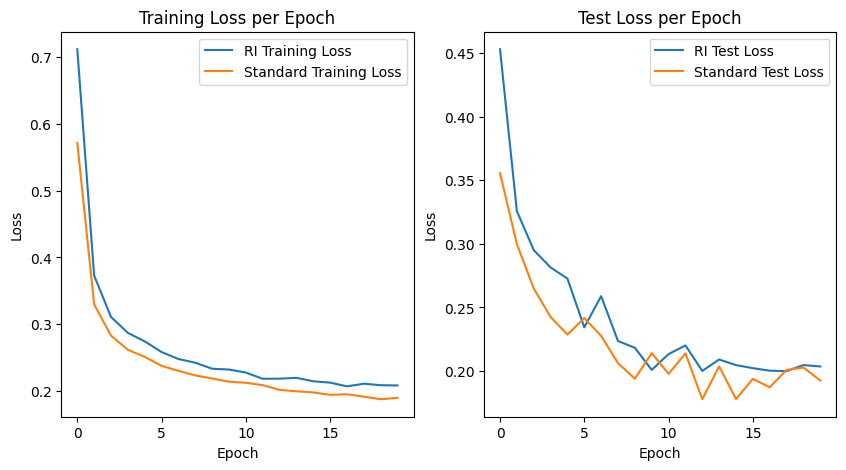

In [10]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(RI_train_losses, label='RI Training Loss')
plt.plot(standard_train_losses, label='Standard Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(RI_test_losses, label='RI Test Loss')
plt.plot(standard_test_losses, label='Standard Test Loss')
plt.title('Test Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

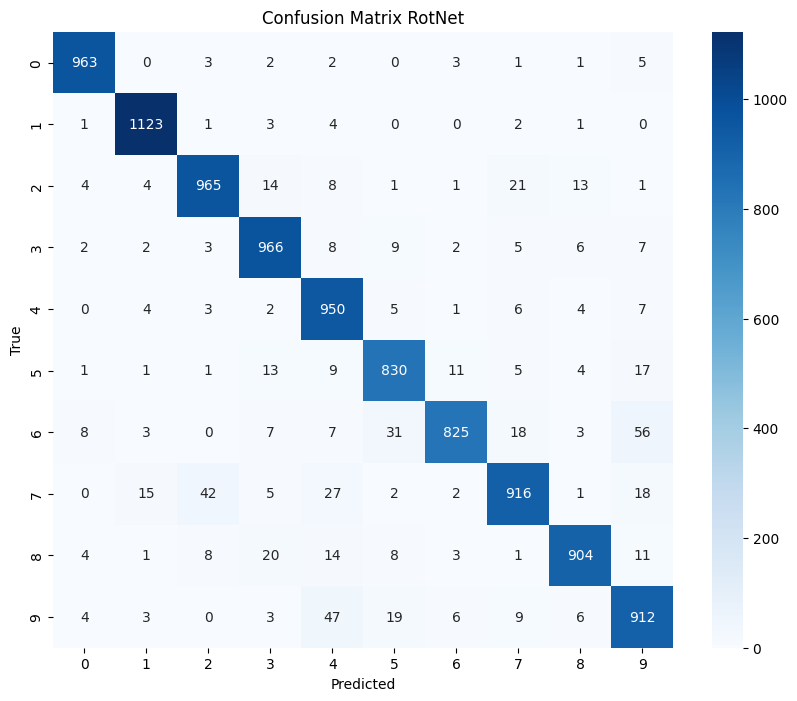

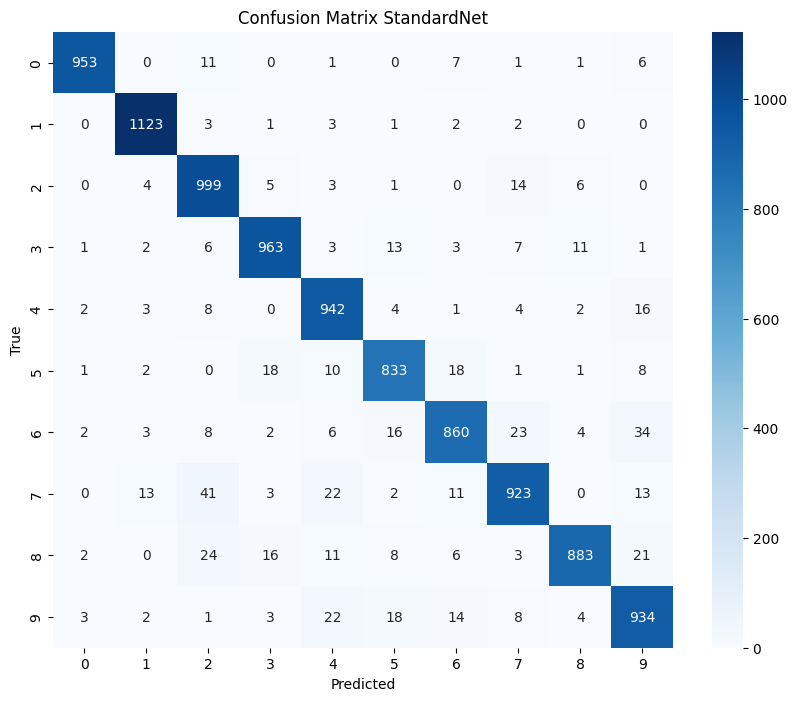

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

with torch.no_grad():
    RI_model.eval()
    predictions, labels = get_all_preds(RI_model, test_loader)
    predictions = torch.argmax(predictions, dim=1)

cm = confusion_matrix(labels.cpu(), predictions.cpu())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix RotNet')
plt.show()

with torch.no_grad():
    standard_model.eval()
    predictions, labels = get_all_preds(standard_model, test_loader)
    predictions = torch.argmax(predictions, dim=1)

cm = confusion_matrix(labels.cpu(), predictions.cpu())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix StandardNet')
plt.show()